# Set up

In [242]:
import datetime as dt
from datetime import date
import numpy as np
import pickle

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import naive_bayes
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.combine import SMOTEENN

from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
import pandas as pd
import pandas.io.sql as pd_sql

# We are also going to do some basic viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Read data for modeling

In [117]:
df=pd.read_pickle('../data/processed/data_for_modeling.pkl')

# Check for class imbalance

In [131]:
df.columns

Index(['category_code', 'days_active', 'participants', 'raised_sum', 'region',
       'round_rank', 'yearly_status'],
      dtype='object')

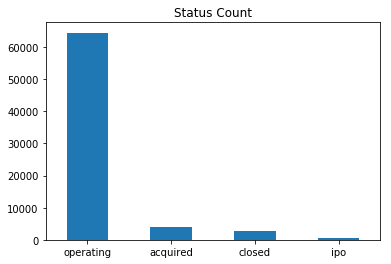

In [132]:
counts=df.yearly_status.value_counts()
counts.plot(kind='bar', title='Status Count', rot=0);

In [133]:
counts

operating    64498
acquired      3831
closed        2776
ipo            612
Name: yearly_status, dtype: int64

# Encode, balance and split data for train and test

In [189]:
X=df[['days_active', 'participants',
       'raised_sum', 'round_rank', 'category_code', 'region']]
y=df['yearly_status']

print(y.shape)

(71717,)


## Encode categorical data

In [190]:
X=pd.get_dummies(X)

In [191]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71717 entries, 0 to 94215
Data columns (total 21 columns):
days_active                      71717 non-null float64
participants                     71717 non-null float64
raised_sum                       71717 non-null float64
round_rank                       71717 non-null float64
category_code_advertising        71717 non-null uint8
category_code_biotech            71717 non-null uint8
category_code_ecommerce          71717 non-null uint8
category_code_enterprise         71717 non-null uint8
category_code_games_video        71717 non-null uint8
category_code_hardware           71717 non-null uint8
category_code_mobile             71717 non-null uint8
category_code_network_hosting    71717 non-null uint8
category_code_other              71717 non-null uint8
category_code_software           71717 non-null uint8
category_code_web                71717 non-null uint8
region_Boston                    71717 non-null uint8
region_Los Angeles 

## Split data to train and test sets

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42,
                                                     stratify=y)

In [193]:
print(X_train.shape)
print(y_train.shape)

(43030, 21)
(43030,)


In [194]:
Counter(y_train)

Counter({'operating': 38699, 'acquired': 2298, 'closed': 1666, 'ipo': 367})

## Try out sampling methods to balance classes

### Use SMOTEENN

In [296]:
# try using SMOTEENN sampling
X_resampled, y_resampled = SMOTEENN(random_state=42).fit_sample(X_train, y_train)

### Use random under and/or over sampling

In [277]:
# try using random under-sampling
#X_rand_resampled, X_rand_resampled = RandomUnderSampler(random_state=42, 
#    sampling_strategy='majority').fit_sample(X_train, y_train)

In [278]:
# try using random over-sampling
#X_rand_resampled, X_rand_resampled = RandomOverSampler(random_state=42, 
#    sampling_strategy='not majority').fit_sample(X_rand_resampled, X_rand_resampled)

### Check counts after sampling

In [279]:
Counter(y_resampled)

Counter({'acquired': 2298, 'closed': 2298, 'ipo': 2298, 'operating': 2298})

In [199]:
class_names=y.unique()

In [200]:
class_names

array(['operating', 'acquired', 'closed', 'ipo'], dtype=object)

# Try different models

## Logistic Regression

In [152]:
pipe = imbPipeline([('undersample', SMOTEENN(random_state=42)),
    ('logr', LogisticRegression(multi_class='ovr', solver='lbfgs'))
    ])

param_grid={"logr__C":[1,5,10,100]}
grid = GridSearchCV(pipe, param_grid, return_train_score=False,
                    n_jobs=-1, scoring='f1_micro', cv=3)

grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('undersample', SMOTEENN(enn=None, random_state=42, ratio=None, sampling_strategy='auto',
     smote=None)), ('logr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'logr__C': [1, 5, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=False, scoring='f1_micro', verbose=0)

In [153]:
print(grid.best_params_)
y_pred=grid.predict(X_resampled)
print(classification_report(y_resampled, y_pred))

{'logr__C': 1}


/Users/pyt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/pyt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    acquired       0.07      0.00      0.00     19317
      closed       0.00      0.00      0.00     20765
         ipo       0.30      1.00      0.46     24991
   operating       0.00      0.00      0.00     18574

   micro avg       0.30      0.30      0.30     83647
   macro avg       0.09      0.25      0.12     83647
weighted avg       0.11      0.30      0.14     83647



/Users/pyt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


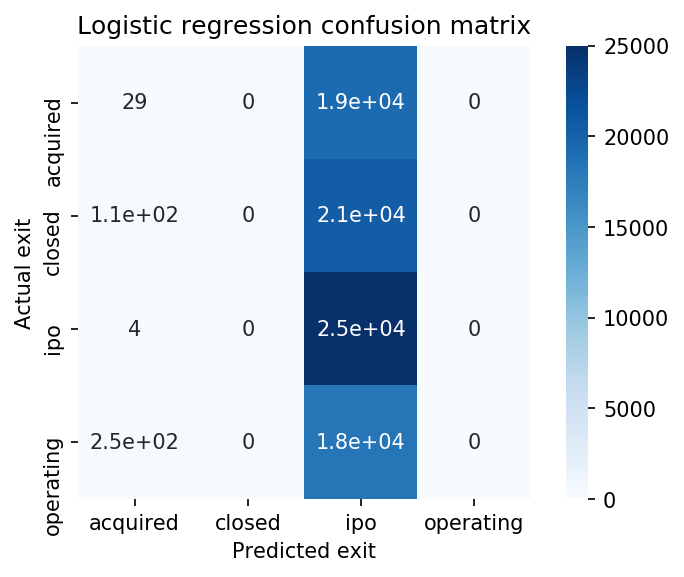

In [154]:
# Print confusion matrix for logistic regression
logr_confusion = confusion_matrix(y_resampled, y_pred)
plt.figure(dpi=150)
sns.heatmap(logr_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['acquired', 'closed', 'ipo', 'operating'],
           yticklabels=['acquired', 'closed', 'ipo', 'operating'])

plt.xlabel('Predicted exit')
plt.ylabel('Actual exit')
plt.title('Logistic regression confusion matrix');

## Naive Bayes

In [155]:
nb_model = naive_bayes.GaussianNB()

y_pred = cross_val_predict(nb_model, X_resampled, y_resampled, cv=3)

In [156]:
print(classification_report(y_resampled, y_pred))

              precision    recall  f1-score   support

    acquired       0.00      0.00      0.00     19317
      closed       0.35      0.94      0.51     20765
         ipo       0.88      0.38      0.53     24991
   operating       0.18      0.16      0.17     18574

   micro avg       0.38      0.38      0.38     83647
   macro avg       0.35      0.37      0.30     83647
weighted avg       0.39      0.38      0.32     83647



## KNN

In [157]:
knn = KNeighborsClassifier(n_neighbors=20)

knn_pipe = imbPipeline([('undersample', SMOTEENN(random_state=42)),
    ('knn', knn)])

# define the parameter values that should be searched
k_range = list(range(10, 101,20))

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(knn__n_neighbors=k_range)

knn_grid = GridSearchCV(knn_pipe, param_grid, return_train_score=False,
                    n_jobs=-1, scoring='f1_macro', cv=3)

knn_grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('undersample', SMOTEENN(enn=None, random_state=42, ratio=None, sampling_strategy='auto',
     smote=None)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'knn__n_neighbors': [10, 30, 50, 70, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1_macro', verbose=0)

In [158]:
# view the complete results (list of named tuples)
print(knn_grid.best_params_)

y_pred=knn_grid.predict(X_resampled)
print(classification_report(y_resampled, y_pred))

{'knn__n_neighbors': 10}
              precision    recall  f1-score   support

    acquired       0.91      0.95      0.93     19317
      closed       0.93      0.96      0.95     20765
         ipo       0.97      0.96      0.96     24991
   operating       0.91      0.83      0.87     18574

   micro avg       0.93      0.93      0.93     83647
   macro avg       0.93      0.93      0.93     83647
weighted avg       0.93      0.93      0.93     83647



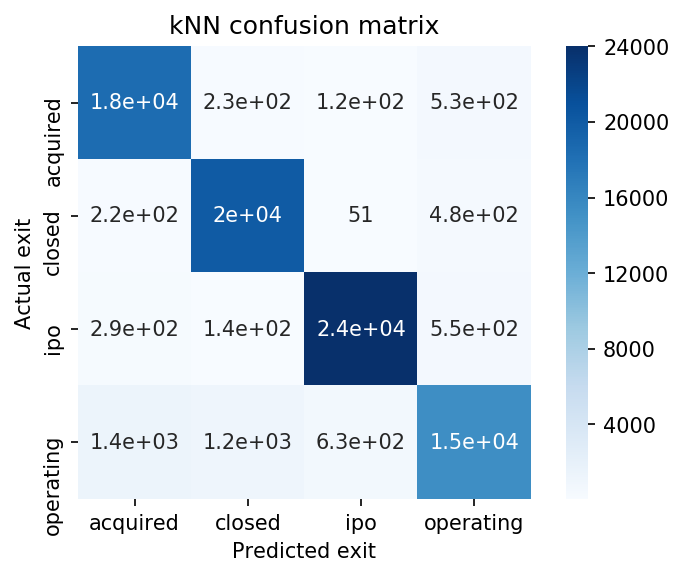

In [159]:
# Print confusion matrix for kNN
knn_confusion = confusion_matrix(y_resampled, y_pred)
plt.figure(dpi=150)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['acquired', 'closed', 'ipo', 'operating'],
           yticklabels=['acquired', 'closed', 'ipo', 'operating'])

plt.xlabel('Predicted exit')
plt.ylabel('Actual exit')
plt.title('kNN confusion matrix');

## GBM (Best)

In [293]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [3,5,10]
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 20]
# Create the random grid
gbm_param_grid = {'gbm__n_estimators': n_estimators,
               'gbm__max_features': max_features,
               'gbm__max_depth': max_depth,
               'gbm__min_samples_split': min_samples_split,
               'gbm__min_samples_leaf': min_samples_leaf}

In [294]:
gbm = GradientBoostingClassifier(random_state=10, n_iter_no_change =5)

gbm_pipe = imbPipeline([('undersample', SMOTEENN(random_state=42)),
    ('gbm', gbm)])

gbm_grid = RandomizedSearchCV(gbm_pipe, gbm_param_grid, return_train_score=False,
                    n_jobs=-1, scoring='f1_macro', cv=5,
                        verbose=2, random_state=42, n_iter=5)

gbm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed: 17.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 17.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('undersample', SMOTEENN(enn=None, random_state=42, ratio=None, sampling_strategy='auto',
     smote=None)), ('gbm', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=N...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'gbm__n_estimators': [200, 650, 1100, 1550, 2000], 'gbm__max_features': ['sqrt'], 'gbm__max_depth': [3, 5, 10], 'gbm__min_samples_split': [10, 20, 100], 'gbm__min_samples_leaf': [5, 10, 20]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=False, scoring='f1_macro', verbose=2)

In [297]:
print(gbm_grid.best_params_)
gbm_y_pred=gbm_grid.predict(X_resampled)
print(classification_report(y_resampled, gbm_y_pred))
gbm_conf_mat = confusion_matrix(y_resampled, gbm_y_pred)

{'gbm__n_estimators': 1550, 'gbm__min_samples_split': 20, 'gbm__min_samples_leaf': 5, 'gbm__max_features': 'sqrt', 'gbm__max_depth': 10}
              precision    recall  f1-score   support

    acquired       1.00      1.00      1.00     19317
      closed       1.00      1.00      1.00     20765
         ipo       1.00      1.00      1.00     24991
   operating       0.99      1.00      1.00     18574

   micro avg       1.00      1.00      1.00     83647
   macro avg       1.00      1.00      1.00     83647
weighted avg       1.00      1.00      1.00     83647



Text(174.58333333333343, 0.5, 'Actual exit')

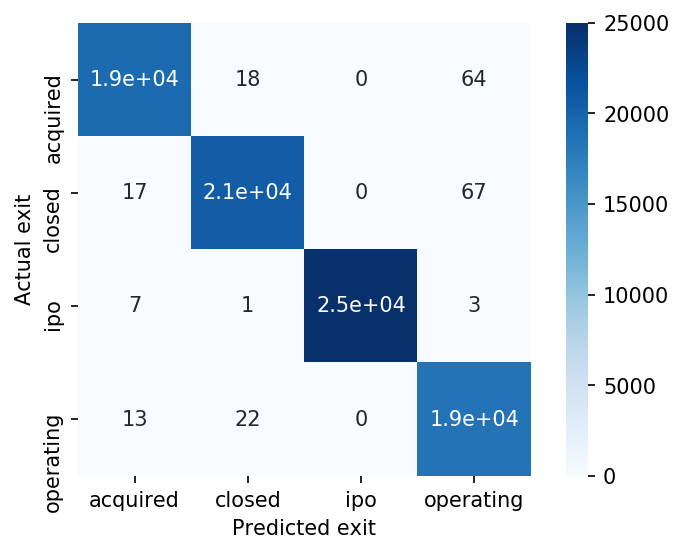

In [298]:
plt.figure(dpi=150)
sns.heatmap(gbm_conf_mat, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['acquired', 'closed', 'ipo', 'operating'],
           yticklabels=['acquired', 'closed', 'ipo', 'operating'])

plt.xlabel('Predicted exit')
plt.ylabel('Actual exit')

In [299]:
gbm_ytr_pred=gbm_grid.predict(X_train)
print(classification_report(y_train, gbm_ytr_pred))

              precision    recall  f1-score   support

    acquired       0.64      0.61      0.63      2298
      closed       0.48      0.65      0.55      1666
         ipo       0.56      0.74      0.64       367
   operating       0.96      0.95      0.95     38699

   micro avg       0.91      0.91      0.91     43030
   macro avg       0.66      0.74      0.69     43030
weighted avg       0.92      0.91      0.92     43030



In [300]:
gbm_ytest_pred=gbm_grid.predict(X_test)
print(classification_report(y_test, gbm_ytest_pred))

              precision    recall  f1-score   support

    acquired       0.35      0.24      0.28      1533
      closed       0.20      0.22      0.21      1110
         ipo       0.30      0.32      0.31       245
   operating       0.92      0.93      0.93     25799

   micro avg       0.86      0.86      0.86     28687
   macro avg       0.44      0.43      0.43     28687
weighted avg       0.85      0.86      0.86     28687



Text(174.58333333333343, 0.5, 'Actual exit')

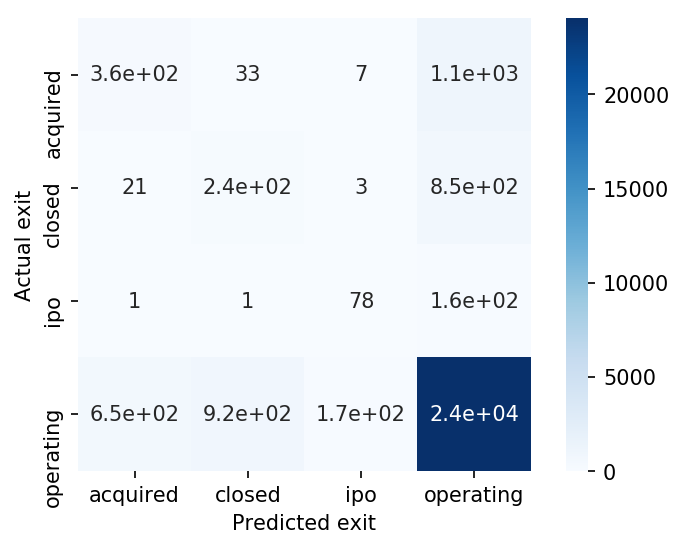

In [301]:
conf_mat = confusion_matrix(y_test, gbm_ytest_pred)
plt.figure(dpi=150)
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['acquired', 'closed', 'ipo', 'operating'],
           yticklabels=['acquired', 'closed', 'ipo', 'operating'])

plt.xlabel('Predicted exit')
plt.ylabel('Actual exit')

In [231]:
best_gbm=gbm_grid.best_estimator_.named_steps.gbm

In [232]:
pickle.dump(best_gbm, open('../models/best_gbm.pkl', 'wb'))

### GBM (tried using over and under random sampling)

In [282]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [3,5,10]
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 20]
# Create the random grid
gbm2_param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [285]:
gbm2 = GradientBoostingClassifier(random_state=10, n_iter_no_change =5)

gbm2_grid = RandomizedSearchCV(gbm2, gbm2_param_grid, return_train_score=False,
                    n_jobs=-1, scoring='f1_macro', cv=5,
                        verbose=2, random_state=42, n_iter=5)

gbm2_grid.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   55.0s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   59.5s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': [200, 650, 1100, 1550, 2000], 'max_features': ['sqrt'], 'max_depth': [3, 5, 10], 'min_samples_split': [10, 20, 100], 'min_samples_leaf': [5, 10, 20]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=False, scoring='f1_macro', verbose=2)

In [286]:
print(gbm2_grid.best_params_)
y_pred=gbm2_grid.predict(X_resampled)
print(classification_report(y_resampled, y_pred))
conf_mat = confusion_matrix(y_resampled, y_pred)

{'n_estimators': 1550, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10}
              precision    recall  f1-score   support

    acquired       0.99      0.98      0.98      2298
      closed       0.99      0.98      0.99      2298
         ipo       1.00      1.00      1.00      2298
   operating       0.99      1.00      1.00      2298

   micro avg       0.99      0.99      0.99      9192
   macro avg       0.99      0.99      0.99      9192
weighted avg       0.99      0.99      0.99      9192



Text(174.58333333333343, 0.5, 'Actual exit')

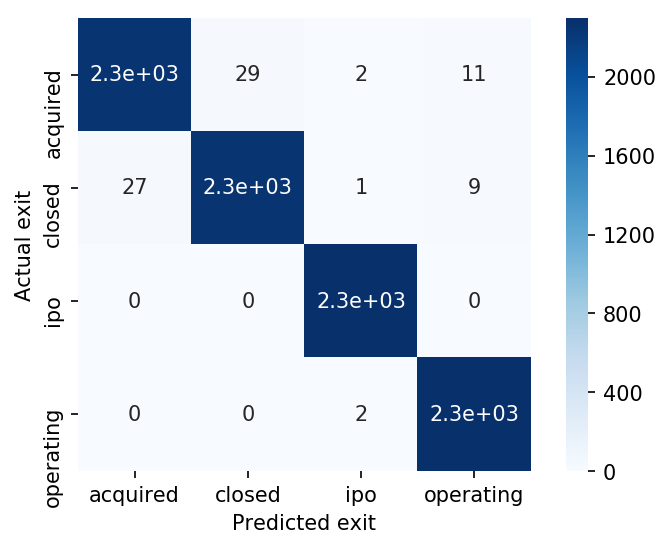

In [287]:
plt.figure(dpi=150)
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['acquired', 'closed', 'ipo', 'operating'],
           yticklabels=['acquired', 'closed', 'ipo', 'operating'])

plt.xlabel('Predicted exit')
plt.ylabel('Actual exit')

In [289]:
ytr_pred=gbm2_grid.predict(X_train)
print(classification_report(y_train, ytr_pred))

              precision    recall  f1-score   support

    acquired       0.11      0.98      0.20      2298
      closed       0.11      0.98      0.19      1666
         ipo       0.13      1.00      0.23       367
   operating       1.00      0.12      0.22     38699

   micro avg       0.21      0.21      0.21     43030
   macro avg       0.34      0.77      0.21     43030
weighted avg       0.91      0.21      0.22     43030



In [290]:
ytest_pred=gbm2_grid.predict(X_test)
print(classification_report(y_test, ytest_pred))

              precision    recall  f1-score   support

    acquired       0.10      0.84      0.17      1533
      closed       0.08      0.76      0.15      1110
         ipo       0.10      0.75      0.17       245
   operating       0.97      0.12      0.21     25799

   micro avg       0.19      0.19      0.19     28687
   macro avg       0.31      0.62      0.18     28687
weighted avg       0.88      0.19      0.20     28687



In [231]:
best_gbm=gbm_grid.best_estimator_.named_steps.gbm

In [232]:
pickle.dump(best_gbm, open('../models/best_gbm.pkl', 'wb'))

## Random Forest

In [213]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 50, 100]
# Create the random grid
random_grid = {'forest__n_estimators': n_estimators,
               'forest__max_features': max_features,
               'forest__max_depth': max_depth,
               'forest__min_samples_split': min_samples_split,
               'forest__min_samples_leaf': min_samples_leaf}

In [214]:
forest_clf=RandomForestClassifier(class_weight='balanced_subsample')
forest_pipe = imbPipeline([('undersample', SMOTEENN(random_state=42, 
    sampling_strategy='auto')),
    ('forest', forest_clf)])
rf_random = RandomizedSearchCV(forest_pipe, param_distributions = random_grid, n_iter = 10, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('undersample', SMOTEENN(enn=None, random_state=42, ratio=None, sampling_strategy='auto',
     smote=None)), ('forest', RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None,...='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'forest__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'forest__max_features': ['auto', 'sqrt'], 'forest__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'forest__min_samples_split': [10, 20, 30], 'forest__min_samples_leaf': [10, 50, 100]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=No

In [215]:
print(rf_random.best_params_)

y_pred=rf_random.predict(X_resampled)
print(classification_report(y_resampled, y_pred))

{'forest__n_estimators': 1800, 'forest__min_samples_split': 20, 'forest__min_samples_leaf': 10, 'forest__max_features': 'auto', 'forest__max_depth': 100}
              precision    recall  f1-score   support

    acquired       0.95      0.90      0.92     19317
      closed       0.97      0.91      0.94     20765
         ipo       0.99      0.99      0.99     24991
   operating       0.87      0.97      0.92     18574

   micro avg       0.95      0.95      0.95     83647
   macro avg       0.94      0.94      0.94     83647
weighted avg       0.95      0.95      0.95     83647



In [216]:
ytr_pred=rf_random.predict(X_train)
print(classification_report(y_train, ytr_pred))

              precision    recall  f1-score   support

    acquired       0.52      0.35      0.42      2298
      closed       0.35      0.33      0.34      1666
         ipo       0.27      0.67      0.39       367
   operating       0.93      0.94      0.94     38699

   micro avg       0.88      0.88      0.88     43030
   macro avg       0.52      0.57      0.52     43030
weighted avg       0.88      0.88      0.88     43030



In [217]:
ytest_pred=rf_random.predict(X_test)
print(classification_report(y_test, ytest_pred))

              precision    recall  f1-score   support

    acquired       0.26      0.14      0.18      1533
      closed       0.16      0.13      0.15      1110
         ipo       0.15      0.35      0.21       245
   operating       0.91      0.93      0.92     25799

   micro avg       0.85      0.85      0.85     28687
   macro avg       0.37      0.39      0.37     28687
weighted avg       0.84      0.85      0.85     28687



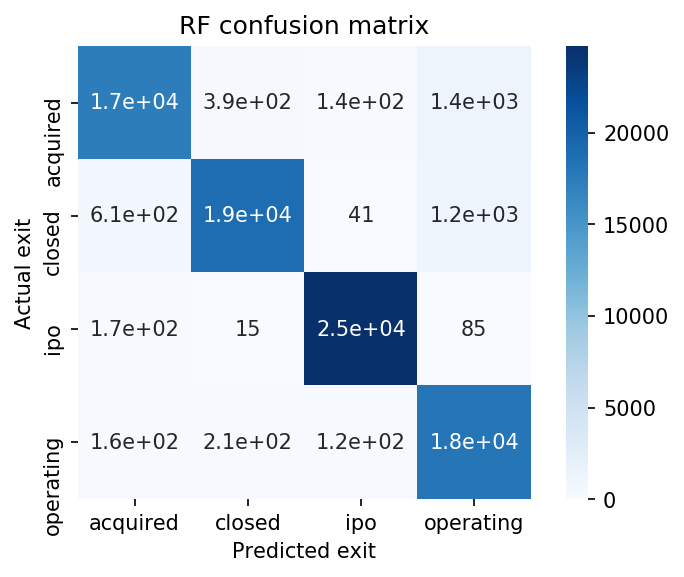

In [218]:
# Print confusion matrix for kNN
rf_confusion = confusion_matrix(y_resampled, y_pred)
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['acquired', 'closed', 'ipo', 'operating'],
           yticklabels=['acquired', 'closed', 'ipo', 'operating'])

plt.xlabel('Predicted exit')
plt.ylabel('Actual exit')
plt.title('RF confusion matrix');

In [219]:
best_rf=rf_random.best_estimator_.named_steps.forest

In [220]:
pickle.dump(best_rf, open('../models/best_rf.pkl', 'wb'))

# Test Predictions

In [265]:
# test pinterest (expect ipo), uber (expect ipo), pivotal (ipo-ed), 
# munchery (acq), Lytro (closed), Webroot (acq)

pinterest=(dt.datetime.now()-dt.datetime(2009, 1, 1, 0, 0)).days
uber=(dt.datetime.now()-dt.datetime(2009, 3, 1, 0, 0)).days
pivotal=(dt.datetime.now()-dt.datetime(2013, 4, 1, 0, 0)).days
munch=(dt.datetime.now()-dt.datetime(2011, 4, 1, 0, 0)).days
lytro=(dt.datetime.now()-dt.datetime(2018, 3, 28, 0, 0)).days
webroot=(dt.datetime.now()-dt.datetime(1997, 1, 1, 0, 0)).days
d={'days_active': [pinterest, uber, pivotal, munch, lytro, webroot], 
        'participants': [37, 97, 5, 21, 17, 3], 
        'raised_sum': [1500000000, 2420000000, 1700000000, 125400000, 215800000, 108900000], 
        'round_rank': [15, 22, 3, 8, 7, 2],
        'category_code_advertising': [0, 0, 0, 0, 0, 0], 
        'category_code_biotech': [0, 0, 0, 0, 0, 0],
        'category_code_ecommerce': [0, 0, 0, 0, 0, 0], 
        'category_code_enterprise': [0, 0, 1, 0, 0, 0],
        'category_code_games_video': [0, 0, 0, 0, 0, 0], 
        'category_code_hardware': [0, 0, 0, 0, 0, 0],
        'category_code_mobile': [0, 1, 0, 0, 0, 0], 
        'category_code_network_hosting': [0, 0, 0, 0, 0, 0],
        'category_code_other': [1, 0, 0, 1, 0, 1], 
        'category_code_software': [0, 0, 0, 0, 1, 0], 
        'category_code_web': [0, 0, 0, 0, 0, 0],
        'region_Boston': [0, 0, 0, 0, 0, 0], 
        'region_Los Angeles': [0, 0, 0, 0, 0, 0], 
        'region_New York': [0, 0, 0, 0, 0, 0],
        'region_SF Bay': [1, 1, 1, 1, 1, 0], 
        'region_Seattle': [0, 0, 0, 0, 0, 0], 
        'region_other': [0, 0, 0, 0, 0, 1]}
X_real=pd.DataFrame(data=d)

In [266]:
y_real_pred=gbm_grid.predict(X_real)

In [267]:
y_real_pred

array(['operating', 'operating', 'acquired', 'operating', 'operating',
       'operating'], dtype=object)